---
Author: Mustapha Bouhsen <br>
[LinkedIn](https://www.linkedin.com/in/mustapha-bouhsen/)<br>
[Git](https://github.com/mus514)<br>
Date: February 9, 2024<br>
---

# Usefull function for the daily loads

In [0]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
from matplotlib import pyplot as plt   #plt.xkcd()
from IPython.display import set_matplotlib_formats
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from itertools import combinations

In [0]:
# Setting the matplotlib format to 'retina' for better display quality
set_matplotlib_formats('retina')
plt.style.use('seaborn-notebook')

/root/.ipykernel/1059/command-1632075165276539-4036587617:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Load the data

In [0]:
returns = spark.sql("SELECT * FROM stocks_returns").toPandas()
prices = spark.sql("SELECT * FROM stocks_prices").toPandas()

In [0]:
stocks = ['aapl', 'amzn', 'msft', 'googl']

In [0]:
def garch(theta, r):
    #Extract the parameters
    w = theta[0]
    a = theta[1]
    b = theta[2]
    T = len(r)
    sigma = np.zeros(T+1)
    sigma[0] = w/(1-a-b)

    for i in range(1, T+1):
        sigma[i] = w+a*(r[i-1]**2)+b*sigma[i-1]

    return sigma

In [0]:
theta = [0.000002, 0.5, 0.48]
r = returns["aapl"]
sigma = garch(theta, r)

<AxesSubplot:ylabel='Count'>

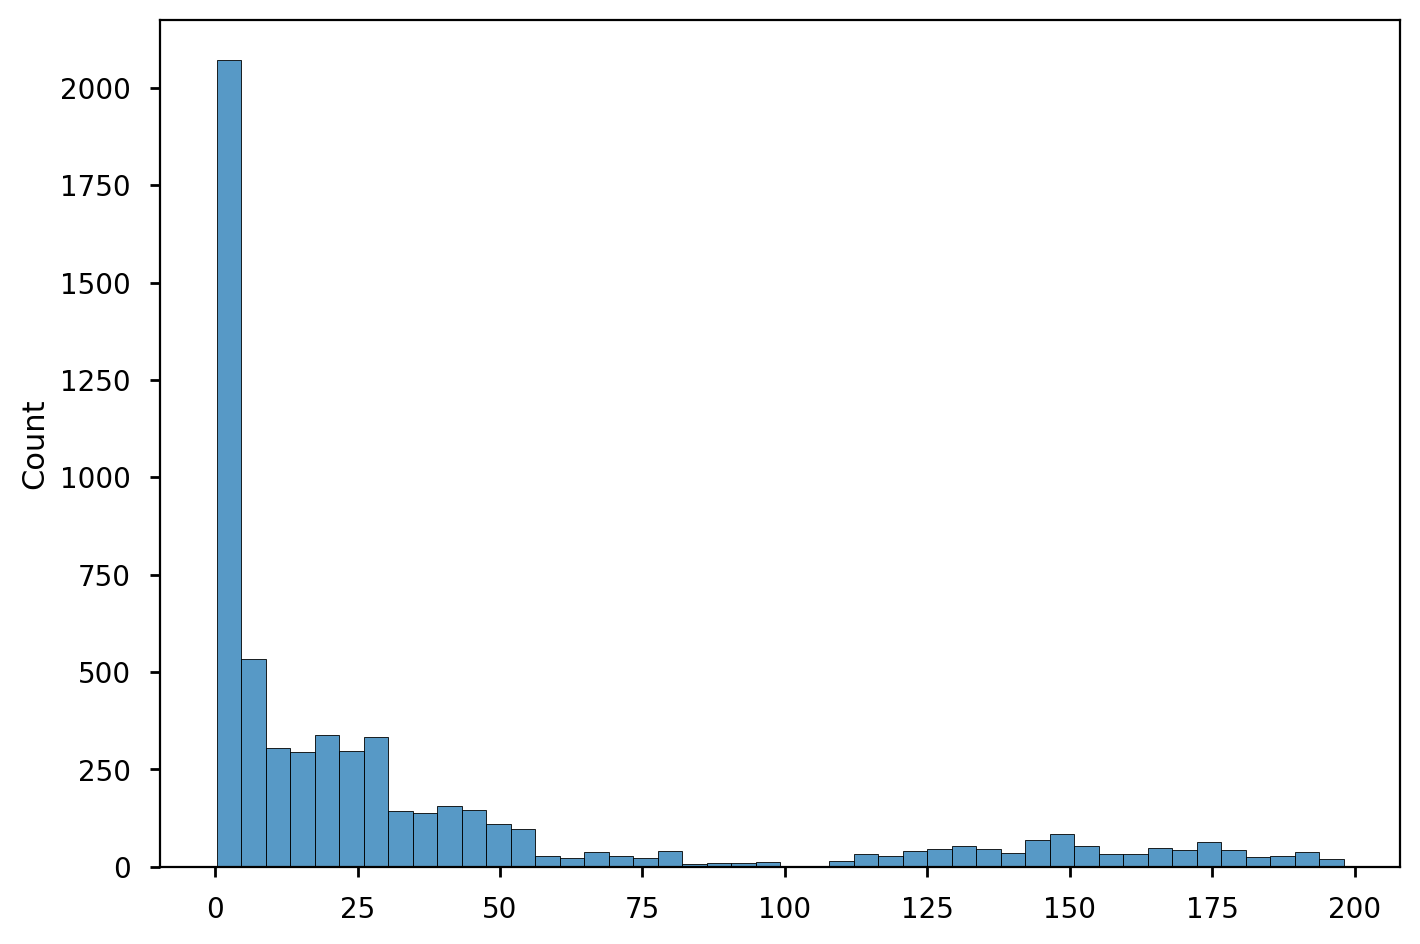

In [0]:
sns.histplot(x=r)

<AxesSubplot:ylabel='Adj Close'>

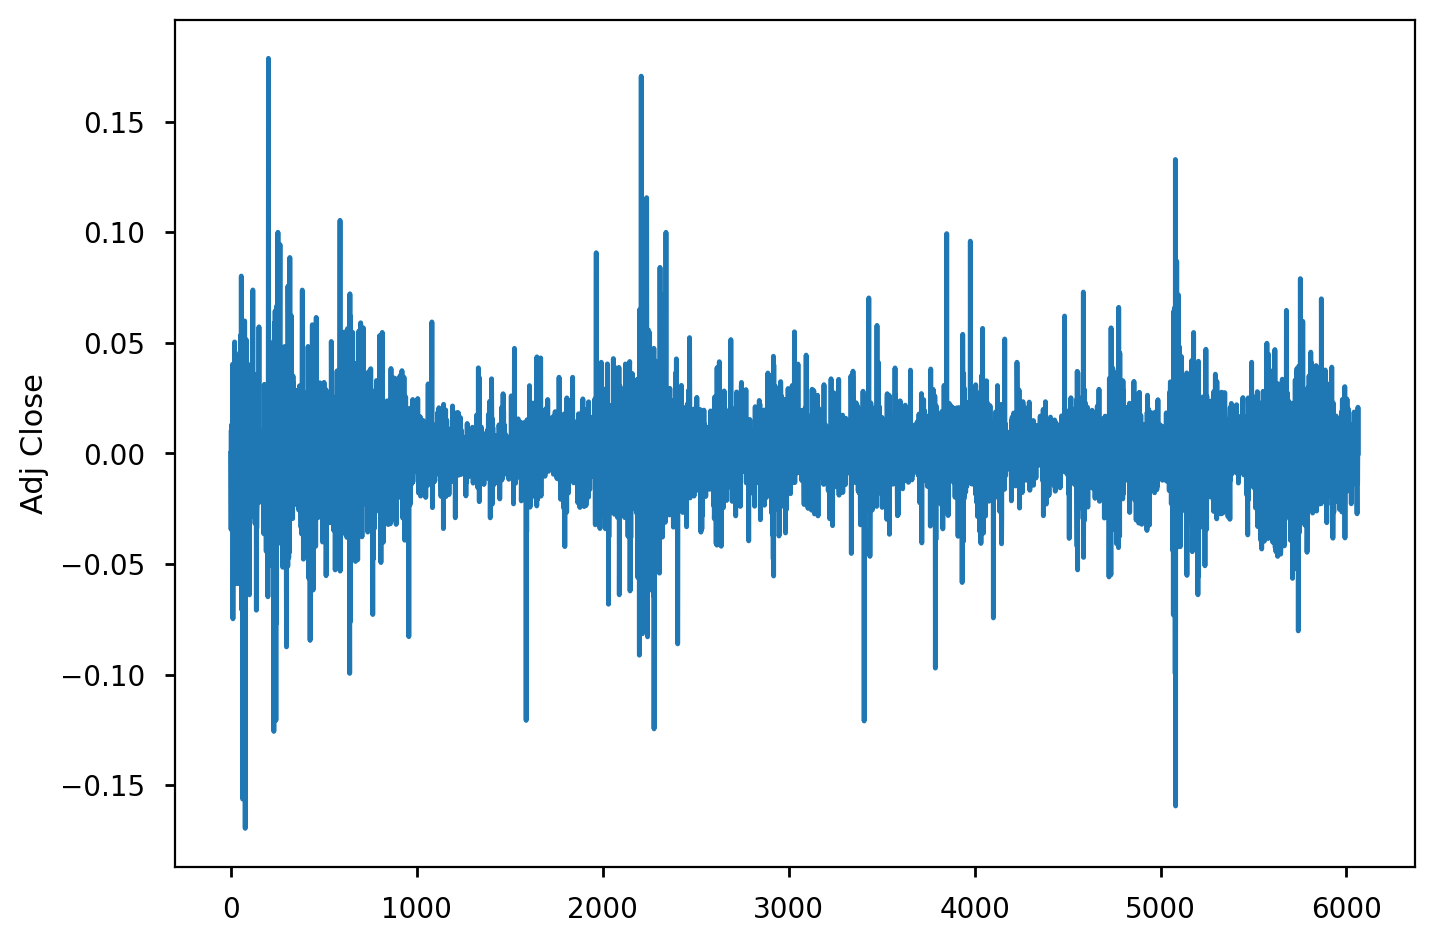

In [0]:
sns.lineplot(y = log_returns, x=range(0, len(r)))

<AxesSubplot:xlabel='date', ylabel='aapl'>

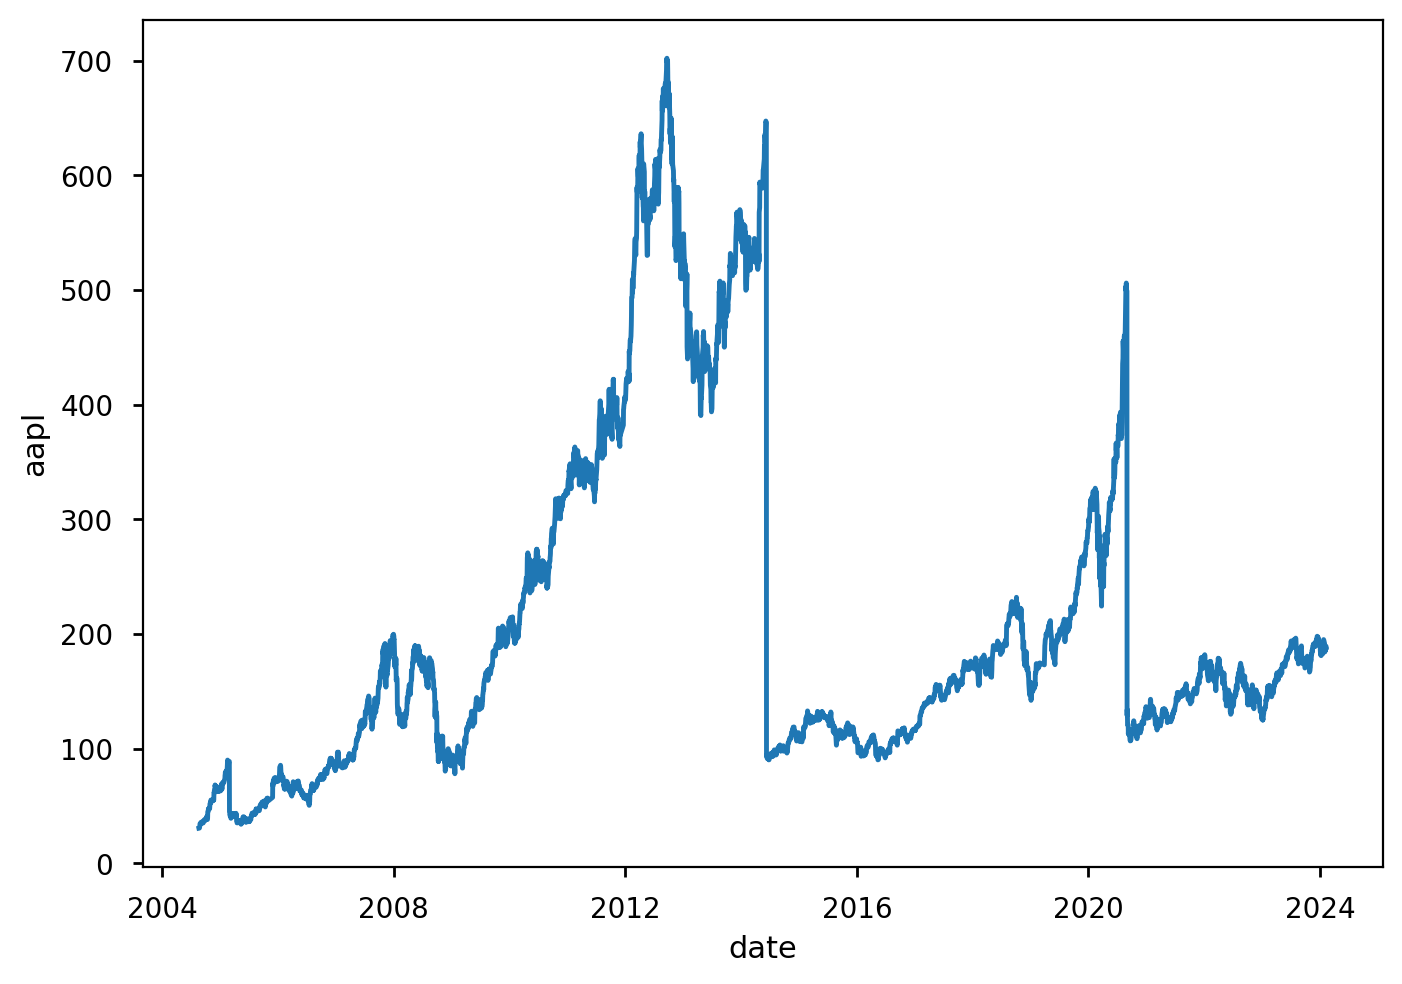

In [0]:
sns.lineplot(y = prices["aapl"], x = returns["date"])

In [0]:
!pip install yfinance
import yfinance as yf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=726003 sha256=7102b6882f88e4cfd175cb9916c36092c0708f14e86f7340eb4127638c7f0202
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Succe

/local_disk0/.ephemeral_nfs/envs/pythonEnv-eac4a061-b010-4e13-906f-73d5ebae032e/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [0]:
stock_symbol = 'MSFT'
start_date = '2000-01-01'
end_date = '2024-02-09'

# Use yfinance to download stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [0]:
r = list(stock_data["Close"])

In [0]:
r[-1]/10000

0.018832000732421875

In [0]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.846127,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.774790,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.786128,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.718097,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.752113,460734400
...,...,...,...,...,...,...
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.613159,102518000
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.440811,69668800
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800


In [0]:
log_returns = stock_data['Adj Close'].pct_change().apply(lambda x: 0 if pd.isna(x) else np.log(1 + x))